In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error,r2_score

In [152]:
ticker = 'SPY'
df = yf.download(ticker, start='2010-01-01', end='2025-05-10')
df = df[['Close']].dropna()              # נשמור רק את עמודת הסגירה
df.rename(columns={'Close': 'Price'}, inplace=True)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


# Add treasury yields 

In [502]:
import openpyxl
sheets_dict = pd.read_excel('treasury_auctions.xlsx', sheet_name=None)
# Extract each sheet into separate DataFrames
df1 = sheets_dict[list(sheets_dict.keys())[0]]
df2 = sheets_dict[list(sheets_dict.keys())[1]]
df3 = sheets_dict[list(sheets_dict.keys())[2]]

# Optional: print sheet names to verify
print("Sheet names:", list(sheets_dict.keys()))

Sheet names: ['20year_auction', '10year_auction', '2year_auction']


In [503]:
df3.head()

,Release Date,Actual,Previous
0,"May 27, 2025",0.03955,0.03795
1,"Apr 22, 2025",0.03795,0.03984
2,"Mar 25, 2025",0.03984,0.04169
3,"Feb 24, 2025",0.04169,0.04211
4,"Jan 27, 2025",0.04211,0.04335


In [504]:
for df in [df1, df2, df3]:
    #df = df.drop('Time', axis=1)
    # 1) Make the first row into the header
    #df.columns = df.iloc[0]
    # 2) Remove that row from the body of the DataFrame
    #df = df.iloc[1:].reset_index(drop=True)
    df['Release Date'] = df['Release Date'].str.replace(r"\s*\(.*\)", "", regex=True)  # remove (anything)
    df['Release Date'] = pd.to_datetime(df['Release Date'], format='%b %d, %Y')
    df['Release Date'] = df['Release Date'].dt.date
    df.rename(columns={'Release Date': 'ds'}, inplace=True)  # rename for consistency

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ds        60 non-null     object 
 1   Actual    60 non-null     float64
 2   Previous  60 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.5+ KB


## Creating gap from auction price 

In [508]:
lst = [(df1,'20year'), (df2,'10year'), (df3,'2year')]
def auction_gap(lst):
    for df, label in lst:
        df['ds'] = df['ds'].astype('datetime64[ns]')
        df[f'{label}_gap'] = df['Actual'] - df['Previous']
        df[f'{label}_gap'] = df[f'{label}_gap'].fillna(0)
        df.rename(columns={'Actual': f'Actual_{label}'}, inplace=True)

    return df1, df2, df3
df1, df2, df3 = auction_gap(lst)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             60 non-null     datetime64[ns]
 1   Actual_20year  60 non-null     float64       
 2   Previous       60 non-null     float64       
 3   20year_gap     60 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.0 KB


In [509]:
for df in [df1, df2, df3]:
    df.drop(columns=['Previous'], inplace=True, errors='ignore')

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             174 non-null    datetime64[ns]
 1   Actual_10year  174 non-null    float64       
 2   10year_gap     174 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.2 KB


In [578]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            165 non-null    datetime64[ns]
 1   Actual_2year  165 non-null    float64       
 2   2year_gap     165 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.0 KB


# The return data:

In [4]:
return_data = pd.read_pickle('df_with_QQQ.pkl')
return_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QQQ_Close        2071 non-null   float64       
 1   ^RUT             2071 non-null   float64       
 2   ^VIX             2071 non-null   float64       
 3   EMA_20           2071 non-null   float64       
 4   ^GDAXI           2071 non-null   float64       
 5   MSFT             2071 non-null   float64       
 6   stdev_5          2071 non-null   float64       
 7   ^FTSE            2071 non-null   float64       
 8   GOOG             2071 non-null   float64       
 9   AAPL             2071 non-null   float64       
 10  high-low         2071 non-null   float64       
 11  avgreturn5d      2071 non-null   float64       
 12  abs_yield_curve  2071 non-null   float64       
 13  std_price        2071 non-null   float64       
 14  UNG              2071 non-null   float64

In [1161]:
QQQ_ = pd.read_pickle('QQQ')
QQQ_.reset_index(inplace=True)
QQQ_.rename(columns={'Close': 'QQQ_Close', 'Volume': 'QQQ_Volume','Date':'ds'}, inplace=True)
QQQ_['ds'] = pd.to_datetime(QQQ_['ds']).dt.date
QQQ_['ds'] = QQQ_['ds'].astype('datetime64[ns]')
QQQ_.info()
qqq = QQQ_[['ds', 'QQQ_Close', 'QQQ_Volume']].copy()
qqq['qqq_std'] = qqq['QQQ_Close'].rolling(window=5).std()
qqq['qqq_mean'] = qqq['QQQ_Close'].rolling(window=5).mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          2084 non-null   datetime64[ns]
 1   QQQ_Close   2084 non-null   float64       
 2   Open        2084 non-null   float64       
 3   High        2084 non-null   float64       
 4   Low         2084 non-null   float64       
 5   QQQ_Volume  2084 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 97.8 KB


In [ ]:
spy_only = pd.read_pickle('combined_cleaned_add.pkl')
spy_only.info()
#spy_only = spy_only.merge(qqq, how='left', on='ds')
spy_only['SPY_std'] = spy_only['SPY_Close'].rolling(window=5).std()
spy_only['SPY_mean'] = spy_only['SPY_Close'].rolling(window=5).mean()
spy_only['SPY_30'] = spy_only['SPY_Close'].rolling(window=30).mean()
#spy_only['qqq_std'] = spy_only['QQQ_Close'].rolling(window=5).std()
#spy_only['qqq_mean'] = spy_only['QQQ_Close'].rolling(window=5).mean()
spy_only = spy_only.dropna()

for_model = spy_only[['SPY_Close', 'SPY_Volume', 'SPY_RSI', '^VIX','MSFT','^TNX','SPY_std','SPY_mean','SPY_30','DX-Y.NYB']].dropna()
#for_model = spy_only[['SPY_Close', 'SPY_Volume', 'SPY_RSI', '^VIX','MSFT','^TNX']].dropna()
#spy_only = spy_only[ 'SPY_Close']
for_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Close            2084 non-null   float64
 1   SPY_Volume           2084 non-null   int64  
 2   AAPL                 2084 non-null   float64
 3   MSFT                 2084 non-null   float64
 4   GOOG                 2084 non-null   float64
 5   GLD                  2084 non-null   float64
 6   SLV                  2084 non-null   float64
 7   ^TNX                 2084 non-null   float64
 8   DX-Y.NYB             2084 non-null   float64
 9   JPY=X                2084 non-null   float64
 10  EUR=X                2084 non-null   float64
 11  USO                  2084 non-null   float64
 12  UNG                  2084 non-null   float64
 13  BTC-USD              2084 non-null   float64
 14  CPER                 2084 non-null   float64
 15  ^VIX                

# Merge with QQQ

In [1163]:
for_model.reset_index(inplace=True)
for_model.rename(columns={'Date': 'ds'}, inplace=True)
for_model = for_model.merge(qqq, how='left', on='ds')
#for_model = for_model.join(qqq, how='left')
for_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          2055 non-null   datetime64[ns]
 1   SPY_Close   2055 non-null   float64       
 2   SPY_Volume  2055 non-null   int64         
 3   SPY_RSI     2055 non-null   float64       
 4   ^VIX        2055 non-null   float64       
 5   MSFT        2055 non-null   float64       
 6   ^TNX        2055 non-null   float64       
 7   SPY_std     2055 non-null   float64       
 8   SPY_mean    2055 non-null   float64       
 9   SPY_30      2055 non-null   float64       
 10  DX-Y.NYB    2055 non-null   float64       
 11  QQQ_Close   2055 non-null   float64       
 12  QQQ_Volume  2055 non-null   int64         
 13  qqq_std     2055 non-null   float64       
 14  qqq_mean    2055 non-null   float64       
dtypes: datetime64[ns](1), float64(12), int64(2)
memory usage: 240.9 KB


In [999]:
# merge the big df with QQQ to export to pickle :
spy = spy_only

spy.reset_index(inplace=True)
spy.rename(columns={'Date': 'ds'}, inplace=True)

DF = spy.merge(qqq, how='left', on='ds')

DF.info()
DF.to_pickle('combined_cleaned_add_with_QQQ.pkl')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2055 non-null   datetime64[ns]
 1   SPY_Close            2055 non-null   float64       
 2   SPY_Volume           2055 non-null   int64         
 3   AAPL                 2055 non-null   float64       
 4   MSFT                 2055 non-null   float64       
 5   GOOG                 2055 non-null   float64       
 6   GLD                  2055 non-null   float64       
 7   SLV                  2055 non-null   float64       
 8   ^TNX                 2055 non-null   float64       
 9   DX-Y.NYB             2055 non-null   float64       
 10  JPY=X                2055 non-null   float64       
 11  EUR=X                2055 non-null   float64       
 12  USO                  2055 non-null   float64       
 13  UNG                  2055 non-nul

In [1479]:
model2_df = DF.copy()
model2_df.drop('ds',axis=1, inplace=True)
model2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Close            2055 non-null   float64
 1   SPY_Volume           2055 non-null   int64  
 2   AAPL                 2055 non-null   float64
 3   MSFT                 2055 non-null   float64
 4   GOOG                 2055 non-null   float64
 5   GLD                  2055 non-null   float64
 6   SLV                  2055 non-null   float64
 7   ^TNX                 2055 non-null   float64
 8   DX-Y.NYB             2055 non-null   float64
 9   JPY=X                2055 non-null   float64
 10  EUR=X                2055 non-null   float64
 11  USO                  2055 non-null   float64
 12  UNG                  2055 non-null   float64
 13  BTC-USD              2055 non-null   float64
 14  CPER                 2055 non-null   float64
 15  ^VIX                 2055 non-null   f

# just to check , dont need to add:

In [605]:
# add the treasury data :
lst = [(df1,'20year'), (df2,'10year'), (df3,'2year')]
def add_data(main,lst1):
    for df,lable in lst:
        main = main.merge(df, on='ds', how='left')
        main[f'Actual_{lable}'] = main[f'Actual_{lable}'].fillna(method='ffill')
        main[f'{lable}_gap'] = main[f'{lable}_gap'].fillna(-5)
        main[f'{lable}_gap'] = main[f'{lable}_gap'].astype(float)
    return main
for_model = add_data(for_model, lst)
for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             2071 non-null   datetime64[ns]
 1   SPY_Close      2071 non-null   float64       
 2   SPY_Volume     2071 non-null   int64         
 3   SPY_RSI        2071 non-null   float64       
 4   ^VIX           2071 non-null   float64       
 5   MSFT           2071 non-null   float64       
 6   ^TNX           2071 non-null   float64       
 7   QQQ_Close      2071 non-null   float64       
 8   QQQ_Volume     2071 non-null   int64         
 9   Actual_20year  1215 non-null   float64       
 10  20year_gap     2071 non-null   float64       
 11  Actual_10year  2059 non-null   float64       
 12  10year_gap     2071 non-null   float64       
 13  Actual_2year   2070 non-null   float64       
 14  2year_gap      2071 non-null   float64       
dtypes: datetime64[ns](1),

C:\Users\OMER\AppData\Local\Temp\ipykernel_28684\683455931.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  main[f'Actual_{lable}'] = main[f'Actual_{lable}'].fillna(method='ffill')
C:\Users\OMER\AppData\Local\Temp\ipykernel_28684\683455931.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  main[f'Actual_{lable}'] = main[f'Actual_{lable}'].fillna(method='ffill')
C:\Users\OMER\AppData\Local\Temp\ipykernel_28684\683455931.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  main[f'Actual_{lable}'] = main[f'Actual_{lable}'].fillna(method='ffill')


# Add some fetures

In [ ]:
#for_model['SPY_std'] = for_model['SPY_Close'].rolling(window=5).std()
#for_model['SPY_mean'] = for_model['SPY_Close'].rolling(window=5).mean()
#for_model['SPY_30'] = for_model['SPY_Close'].rolling(window=30).mean()
#for_model['qqq_std'] = for_model['QQQ_Close'].rolling(window=5).std()
#for_model['qqq_mean'] = for_model['QQQ_Close'].rolling(window=5).mean()
#for_model = for_model.dropna()
#for_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2042 entries, 29 to 2070
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          2042 non-null   datetime64[ns]
 1   SPY_Close   2042 non-null   float64       
 2   SPY_Volume  2042 non-null   int64         
 3   SPY_RSI     2042 non-null   float64       
 4   ^VIX        2042 non-null   float64       
 5   MSFT        2042 non-null   float64       
 6   ^TNX        2042 non-null   float64       
 7   QQQ_Close   2042 non-null   float64       
 8   QQQ_Volume  2042 non-null   int64         
 9   SPY_std     2042 non-null   float64       
 10  SPY_mean    2042 non-null   float64       
 11  SPY_30      2042 non-null   float64       
 12  qqq_std     2042 non-null   float64       
 13  qqq_mean    2042 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(2)
memory usage: 239.3 KB


In [25]:
spy_only = spy_only.to_frame()
spy_only.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SPY_Close  2084 non-null   float64
dtypes: float64(1)
memory usage: 97.1 KB


In [140]:
spy_only = spy_only.iloc[:,:2]

In [ ]:
#x1 = return_data.drop(columns=['SPY_return','ds'])
#y1 = return_data['SPY_return']
#scale1 = MinMaxScaler()
#X_scaled1 = scale1.fit_transform(x1)
#y_scaled1 = scale1.fit_transform(y1.values.reshape(-1, 1))

# Normilize

In [1164]:
for_model = for_model.drop(columns=['ds'])
#features = ['Price', 'Rolling Mean 5', 'Rolling Mean 30', 'Rolling Std 5', 'Rolling Std 30']
scaler = MinMaxScaler()
#arr = spy_only.values.reshape(-1, 1) 

scaled_data = scaler.fit_transform(for_model)
#scaled_data = scaler.fit_transform(spy_only['SPY_Close'].values.reshape(-1, 1))
print(f"The model will get {scaled_data.shape[1]} features for each timestep")

The model will get 14 features for each timestep


# Creat sequence

In [1227]:
def create_sequences_multifeature(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i, 0])  # תחזית רק למחיר
    return np.array(X), np.array(y)

window_size = 22
X, y = create_sequences_multifeature(scaled_data, window_size)

In [533]:
print(y)

[0.01113457 0.01061502 0.01078906 ... 0.81105019 0.80865937 0.77770533]


In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(X.shape[2])

14


### A function to prepare the data 

In [1480]:
def prepare_RNN_data(data,window_size,split_ratio=0.8):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = create_sequences_multifeature(scaled_data, window_size)
    split = int(split_ratio * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    return X_train, X_test, y_train, y_test

In [1482]:
window_size = 30
X_train, X_test, y_train, y_test = prepare_RNN_data(model2_df, 30) # for sequence length of 30

# Loop to pick the best layers :

### 4 layers :

In [972]:
import itertools
import tensorflow as tf

best_val = float("inf")
best_config = None
for n_layers in [1,2,3,4]:
    for units_combo in itertools.product([32,64,98,128], repeat=n_layers):
        # manually build a model with n_layers and units_combo
        model = Sequential()
        for i, u in enumerate(units_combo):
            ret_seq = (i < n_layers - 1)
            if i == 0:
                model.add(GRU(u, return_sequences=ret_seq,
                              input_shape=(window_size, X_train.shape[2])))
            else:
                model.add(GRU(u, return_sequences=ret_seq))
        model.add(Dense(32,activation='relu')) # this I added to improve performance
        model.add(Dense(1))
        model.compile(optimizer="adam", loss="mse")
        history = model.fit(
            X_train, y_train,
            epochs=20, batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss")],
            verbose=0
        )
        val_loss = min(history.history["val_loss"])
        if val_loss < best_val:
            best_val = val_loss
            best_config = (n_layers, units_combo)

print("Best validation loss", best_val, "with", best_config)


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best validation loss 0.0004690174828283489 with (1, (98,))


### 3 layers :

In [1012]:
import itertools
import tensorflow as tf

best_val = float("inf")
best_config = None
for n_layers in [1,2,3]:
    for units_combo in itertools.product([32,64,98], repeat=n_layers):
        # manually build a model with n_layers and units_combo
        model = Sequential()
        for i, u in enumerate(units_combo):
            ret_seq = (i < n_layers - 1)
            if i == 0:
                model.add(GRU(u, return_sequences=ret_seq,
                              input_shape=(window_size, X_train.shape[2])))
            else:
                model.add(GRU(u, return_sequences=ret_seq))
        #model.add(Dense(16,activation='relu')) # this I added to improve performance
        model.add(Dense(1))
        model.compile(optimizer="adam", loss="mse")
        history = model.fit(
            X_train, y_train,
            epochs=20, batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss")],
            verbose=0
        )
        val_loss = min(history.history["val_loss"])
        if val_loss < best_val:
            best_val = val_loss
            best_config = (n_layers, units_combo)

print("Best validation loss", best_val, "with", best_config)


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best validation loss 0.00042345275869593024 with (2, (98, 98))


# To identify rhe nest hyperparameters (Big program):

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import kerastuner as kt   # or `import keras_tuner as kt` depending on your version

def build_model(hp):
    """
    This function returns a compiled Keras model whose architecture
    depends on hyperparameters chosen by KerasTuner.
    """
    model = Sequential()
    # Input shape = (timesteps, n_features)
    # We will assume window_size and n_features are known globally or passed in somehow:
    window_size = 5
    n_features = X_train.shape[2]

    # 1) Choose how many GRU layers to stack (from 1 to 4).
    n_layers = hp.Int("n_gru_layers", min_value=1, max_value=4, step=1)

    for i in range(n_layers):
        # 2) For each layer, choose a unit size from {16, 32, 64, 128, 256}
        units = hp.Choice(f"gru_units_{i}", [16, 32, 64, 128, 256])

        # 3) If it's the **last** GRU layer in the stack, we do NOT return sequences;
        #    otherwise, set return_sequences=True so the next GRU can read a full 3D tensor.
        return_seq = True if (i < n_layers - 1) else False

        if i == 0:
            # First GRU needs input_shape
            model.add(
                GRU(
                    units,
                    return_sequences=return_seq,
                    input_shape=(window_size, n_features)
                )
            )
        else:
            # Subsequent GRUs pick up from the previous layer’s output
            model.add(GRU(units, return_sequences=return_seq))

        # 4) Optionally tune a dropout rate after each GRU
        if hp.Boolean(f"use_dropout_after_gru_{i}"):
            rate = hp.Float(f"dropout_rate_{i}",  min_value=0.0, max_value=0.5, step=0.1)
            model.add(Dropout(rate))

    # 5) Now stack one or two Dense layers before the final output.
    n_dense_layers = hp.Int("n_dense_layers", min_value=0, max_value=2, step=1)
    for j in range(n_dense_layers):
        dense_units = hp.Choice(f"dense_units_{j}", [16, 32, 64, 128])
        model.add(Dense(dense_units, activation="relu"))

    # 6) Final output is a single number (e.g. regression)
    model.add(Dense(1, activation="linear"))

    # 7) Choose optimizer and learning rate
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [ ]:
from kerastuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective="val_mae",        # Or "val_loss", whatever you want to minimize
    max_trials=20,              # how many different hyperparameter combos to try
    executions_per_trial=1,     # how many times to train each model (averaging results)
    directory="my_tuner_dir",
    project_name="gru_architecture_search"
)

# Display search space summary:
tuner.search_space_summary()

# Now run the search. Supply your training data + a validation split or separate (X_val, y_val).
tuner.search(
    X_train,        # shape = (n_samples, window_size, n_features)
    y_train,        # shape = (n_samples, )
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
)


### Pick the best Parameters

In [ ]:
# Show a summary of the best hyperparameters found
tuner.results_summary()

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best # GRU layers:",
      best_hps.get("n_gru_layers"))
for i in range(best_hps.get("n_gru_layers")):
    print(" GRU units in layer", i, "→", best_hps.get(f"gru_units_{i}"))
    print(" Use dropout after GRU layer", i, "=", best_hps.get(f"use_dropout_after_gru_{i}"))
    if best_hps.get(f"use_dropout_after_gru_{i}"):
        print("  Dropout rate:", best_hps.get(f"dropout_rate_{i}"))

print("Best # Dense layers:", best_hps.get("n_dense_layers"))
for j in range(best_hps.get("n_dense_layers")):
    print(" Dense units in layer", j, "→", best_hps.get(f"dense_units_{j}"))

print("Best learning rate:", best_hps.get("learning_rate"))

# Retrieve a compiled model using those hyperparameters, then train it to convergence:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)]
)


# Training functions:

In [1532]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_lstm(
    X_train, y_train,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path='best_lstm.h5',
    dense_units=None,
    dense_activation='relu'
):
    """
    Builds, compiles, and trains a multi-layer LSTM model, with optional intermediate Dense layer.

    Parameters:
    - X_train, y_train: training data arrays
    - learning_rate: float, optimizer learning rate
    - epochs: int, max training epochs
    - num_layers: int, number of LSTM layers
    - units: tuple of ints, units per LSTM layer (length must equal num_layers)
    - window_size: int, sequence length (timesteps)
    - batch_size: int
    - validation_split: float
    - patience: int, early stopping patience
    - checkpoint_path: str, filepath to save best model
    - dense_units: int or None, if specified adds Dense(dense_units, activation=dense_activation)
    - dense_activation: str, activation for the optional Dense layer

    Returns:
    - model: trained Keras model
    - history: training history
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal length of units tuple ({len(units)})")
    
    opt = Adam(learning_rate=learning_rate)
    model = Sequential()
    
    # Add LSTM layers
    for i, u in enumerate(units):
        return_seq = (i < num_layers - 1)
        if i == 0:
            model.add(LSTM(u, return_sequences=return_seq, input_shape=(window_size, X_train.shape[2])))
        else:
            model.add(LSTM(u, return_sequences=return_seq))
    
    # Optional Dense layer
    if dense_units is not None:
        model.add(Dense(dense_units, activation=dense_activation))
    # Output layer
    model.add(Dense(1))
    
    model.compile(optimizer=opt, loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                          save_best_only=True, verbose=1)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1
    )
    return model, history

def train_gru(
    X_train, y_train,
    learning_rate=0.001,
    epochs=20,
    num_layers=1,
    units=(64,),
    window_size=None,
    batch_size=32,
    validation_split=0.2,
    patience=3,
    checkpoint_path='best_gru.h5',
    dense_units=None,
    dense_activation='relu'
):
    """
    Builds, compiles, and trains a multi-layer GRU model (on GPU if available), with optional Dense layer.

    Parameters: same as train_lstm.
    """
    if num_layers != len(units):
        raise ValueError(f"num_layers ({num_layers}) must equal length of units tuple ({len(units)})")
    
    # Choose device
    device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    with tf.device(device):
        opt = Adam(learning_rate=learning_rate)
        model = Sequential()
        # Add GRU layers
        for i, u in enumerate(units):
            return_seq = (i < num_layers - 1)
            if i == 0:
                model.add(GRU(u, return_sequences=return_seq, input_shape=(window_size, X_train.shape[2])))
            else:
                model.add(GRU(u, return_sequences=return_seq))
        # Optional Dense layer
        if dense_units is not None:
            model.add(Dense(dense_units, activation=dense_activation))
        # Output layer
        model.add(Dense(1))
        model.compile(optimizer=opt, loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    chk = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                          save_best_only=True, verbose=1)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[es, chk],
        verbose=1
    )
    return model, history


In [1543]:
model_lstm = train_lstm(
    X_train, y_train,
    learning_rate=0.005,
    epochs=30,
    num_layers=3,
    units=(94, 92, 90),
    window_size=30,
    batch_size=32,
    validation_split=0.2,
    patience=5,
    checkpoint_path='best_lstm.h5',
    dense_units=16,
    dense_activation='relu'
)[0]

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0574
Epoch 1: val_loss improved from inf to 0.01312, saving model to best_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - loss: 0.0567 - val_loss: 0.0131
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0011
Epoch 2: val_loss improved from 0.01312 to 0.00256, saving model to best_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 7.0630e-04
Epoch 3: val_loss improved from 0.00256 to 0.00168, saving model to best_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 7.0632e-04 - val_loss: 0.0017
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 4.1158e-04
Epoch 4: val_loss improved from 0.00168 to 0.00157, saving model to best_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 4.1346e-04 - val_loss: 0.0016
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 4.0641e-04
Epoch 5: val_loss did not improve from 0.00157
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 4.0648e-04 - val_loss: 0.0031
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 4.5550e-04
Epoch 6: val_loss did not improve from 0.00157
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 4.5604e-04 - val_loss: 0.0033
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 4.9223e-04
Epoch 7: val_loss did not improve from 0.00157
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 4.9222e-04 - val_loss: 0.0016
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 3.6889e-04
Epoch 8: val_loss did not improve from 0.00157
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 3.6975e-04 - val_loss: 0.0035
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 3.7415e-04
Epoch 9: val_loss improved from 0.00157 to 0.00126, saving mod

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 3.7349e-04 - val_loss: 0.0013
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 2.9043e-04
Epoch 10: val_loss did not improve from 0.00126
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 2.9107e-04 - val_loss: 0.0030
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 3.2391e-04
Epoch 11: val_loss did not improve from 0.00126
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 3.2397e-04 - val_loss: 0.0029
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 3.0944e-04
Epoch 12: val_loss did not improve from 0.00126
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 3.0971e-04 - val_loss: 0.0016
Epoch 13/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 3.0434e-04
Epoch 13: val_loss did not improve from 0.00126
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 3.0354e-04 - val_loss: 0.0041
Epoch 14/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 5.0612e-04
Epoch 14: val_loss improved from 0.00126 to 0.00078, 

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 5.0740e-04 - val_loss: 7.7873e-04
Epoch 15/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 3.2876e-04
Epoch 15: val_loss improved from 0.00078 to 0.00071, saving model to best_lstm.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 3.2905e-04 - val_loss: 7.1246e-04
Epoch 16/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 3.5183e-04
Epoch 16: val_loss did not improve from 0.00071
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 3.5196e-04 - val_loss: 7.5395e-04
Epoch 17/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 2.7388e-04
Epoch 17: val_loss did not improve from 0.00071
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 2.7395e-04 - val_loss: 0.0011
Epoch 18/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 2.4727e-04
Epoch 18: val_loss did not improve from 0.00071
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - loss: 2.4796e-04 - val_loss: 0.0027
Epoch 19/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 3.3375e-04
Epoch 19: val_loss did not improve from 0.00071
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 3.3308e-04 - val_loss: 0.0011
Epoch 20/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 1.9177e-04
Epoch 20: val_loss did not improve from 0.000

In [ ]:
model_gru = train_gru(
    X_train, y_train,
    learning_rate=0.005,
    epochs=30,
    num_layers=1,
    units=(94,),
    window_size=30,
    batch_size=32,
    validation_split=0.2,
    patience=5,
    checkpoint_path='best_gru.h5',
    dense_units=None,
    dense_activation='relu'
)[0]

Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3003
Epoch 1: val_loss improved from inf to 0.00338, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2920 - val_loss: 0.0034
Epoch 2/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024
Epoch 2: val_loss improved from 0.00338 to 0.00327, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 3/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.4042e-04
Epoch 3: val_loss improved from 0.00327 to 0.00289, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.3885e-04 - val_loss: 0.0029
Epoch 4/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.2042e-04
Epoch 4: val_loss improved from 0.00289 to 0.00279, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2020e-04 - val_loss: 0.0028
Epoch 5/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6893e-04
Epoch 5: val_loss improved from 0.00279 to 0.00240, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6845e-04 - val_loss: 0.0024
Epoch 6/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1467e-04
Epoch 6: val_loss improved from 0.00240 to 0.00215, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.1497e-04 - val_loss: 0.0021
Epoch 7/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7178e-04
Epoch 7: val_loss did not improve from 0.00215
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.7211e-04 - val_loss: 0.0026
Epoch 8/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5278e-04
Epoch 8: val_loss did not improve from 0.00215
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.5303e-04 - val_loss: 0.0025
Epoch 9/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.5713e-04
Epoch 9: val_loss did not improve from 0.00215
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5713e-04 - val_loss: 0.0022
Epoch 10/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3425e-04
Epoch 10: val_loss did not improve from 0.00215
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3454e-04 - val_loss: 0.0025
Epoch 11/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3923e-04
Epoch 11: val_loss improved from 0.00215 to 0.00207, saving model to 

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3953e-04 - val_loss: 0.0021
Epoch 12/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3327e-04
Epoch 12: val_loss did not improve from 0.00207
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3306e-04 - val_loss: 0.0022
Epoch 13/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0797e-04
Epoch 13: val_loss did not improve from 0.00207
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0866e-04 - val_loss: 0.0024
Epoch 14/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3114e-04
Epoch 14: val_loss improved from 0.00207 to 0.00184, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3074e-04 - val_loss: 0.0018
Epoch 15/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4297e-04
Epoch 15: val_loss did not improve from 0.00184
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4201e-04 - val_loss: 0.0021
Epoch 16/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0887e-04
Epoch 16: val_loss did not improve from 0.00184
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0932e-04 - val_loss: 0.0024
Epoch 17/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2295e-04
Epoch 17: val_loss improved from 0.00184 to 0.00171, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2368e-04 - val_loss: 0.0017
Epoch 18/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4497e-04
Epoch 18: val_loss improved from 0.00171 to 0.00140, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.4512e-04 - val_loss: 0.0014
Epoch 19/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3652e-04
Epoch 19: val_loss did not improve from 0.00140
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3574e-04 - val_loss: 0.0022
Epoch 20/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1504e-04
Epoch 20: val_loss did not improve from 0.00140
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1526e-04 - val_loss: 0.0023
Epoch 21/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1519e-04
Epoch 21: val_loss did not improve from 0.00140
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1514e-04 - val_loss: 0.0015
Epoch 22/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4615e-04
Epoch 22: val_loss improved from 0.00140 to 0.00139, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4513e-04 - val_loss: 0.0014
Epoch 23/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3029e-04
Epoch 23: val_loss did not improve from 0.00139
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.2991e-04 - val_loss: 0.0016
Epoch 24/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.1667e-05
Epoch 24: val_loss did not improve from 0.00139
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.1917e-05 - val_loss: 0.0018
Epoch 25/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.5131e-05
Epoch 25: val_loss did not improve from 0.00139
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.5456e-05 - val_loss: 0.0015
Epoch 26/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0041e-04
Epoch 26: val_loss improved from 0.00139 to 0.00124, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.0090e-04 - val_loss: 0.0012
Epoch 27/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3061e-04
Epoch 27: val_loss did not improve from 0.00124
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3094e-04 - val_loss: 0.0015
Epoch 28/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.0566e-05
Epoch 28: val_loss did not improve from 0.00124
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.0801e-05 - val_loss: 0.0016
Epoch 29/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.8160e-05
Epoch 29: val_loss improved from 0.00124 to 0.00072, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.8789e-05 - val_loss: 7.2061e-04
Epoch 30/30
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.1857e-05
Epoch 30: val_loss improved from 0.00072 to 0.00060, saving model to best_gru.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.2166e-05 - val_loss: 5.9771e-04


# LSTM model

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.005)
model_lstm = Sequential([
    LSTM(96, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
    #LSTM(98, return_sequences=False),
    #Dense(16, activation='relu'),
    #Dense(10, activation='relu'),
    Dense(1)
])
model_lstm.compile(optimizer=opt, loss='mse')
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1416]:

opt = Adam(learning_rate=0.0025)
model_lstm = Sequential([
    LSTM(96, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
    #LSTM(96, return_sequences=False),
    #Dense(16, activation='relu'),
    #Dense(1, activation='relu'),
    #Dense(16),
    #Dense(4),
    Dense(1)
])
model_lstm.compile(optimizer=opt, loss='mse')
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1440]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

# 1) Define optimizer as before
opt = Adam(learning_rate=0.0025)

# 2) Build your model
model_lstm = Sequential([
    LSTM(96, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
    #Dense(10, activation='relu'),  # optional hidden layer
    Dense(1)
])

# 3) Compile
model_lstm.compile(optimizer=opt, loss='mse')

# 4) Create an EarlyStopping callback
es = EarlyStopping(
    monitor='val_loss',        # watch validation loss
    patience=3,                # stop after 3 epochs with no improvement
    restore_best_weights=True  # roll back to the best weights observed
)
chkpt = ModelCheckpoint(
    filepath='best_model.h5',     # where to save
    monitor='val_loss',           # what metric to watch
    verbose=1,                    # print a message when saving
    save_best_only=True,          # only keep the best version
    save_weights_only=False,      # save the full model (architecture+weights)
    mode='auto',                  # infer direction from the monitored metric
    save_freq='epoch'             # check after every epoch
)

# 5) Fit with a validation split (or use validation_data=(X_test, y_test))
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,      # or validation_data=(X_test, y_test)
    callbacks=[es],
    verbose=1
)


Epoch 1/30


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0364 - val_loss: 8.5508e-04
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.4731e-04 - val_loss: 8.5138e-04
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.6353e-04 - val_loss: 6.4607e-04
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2805e-04 - val_loss: 6.9456e-04
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.0686e-04 - val_loss: 5.8935e-04
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.2409e-04 - val_loss: 5.3736e-04
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.0045e-04 - val_loss: 5.3065e-04
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6333e-04 - val_loss: 5.7166e-04
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6592e-04 - val_loss: 5.5772e-04
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.5609e-04 - val_loss: 4.9630e-04
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3441e-04 - val_loss: 6

# GRU model:

In [ ]:
model_gru = Sequential([
    GRU(98, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    GRU(64, return_sequences=True),
    GRU(44),
    Dense(32, activation='relu'),
    Dense(16),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [1041]:
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    GRU(98, return_sequences=True),
    GRU(64, return_sequences=True),
    GRU(44, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(16,),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [847]:
model_gru = Sequential([
    GRU(98, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    GRU(64, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(16),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [968]:
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    GRU(128, return_sequences=False),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

In [1175]:
model_gru = Sequential([
    GRU(98, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    GRU(98, return_sequences=False),
    #Dense(16, activation='relu'),
    #Dense(16, activation='relu'),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Inverse the scale

In [1534]:
pred_lstm = model_lstm.predict(X_test)
pred_gru = model_gru.predict(X_test)

# reset the scaler to the original price range
price_scaler = MinMaxScaler()
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
pred_lstm = price_scaler.inverse_transform(pred_lstm)
pred_gru = price_scaler.inverse_transform(pred_gru)
y_test_actual = price_scaler.inverse_transform(y_test.reshape(-1, 1))
#y_test_actual = price_scaler.inverse_transform(y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [1444]:
#dates = spy_only.index[window_size + split:]
dates = for_model.index[window_size + split:]
#dates = y_test_actual[window_size + split:]


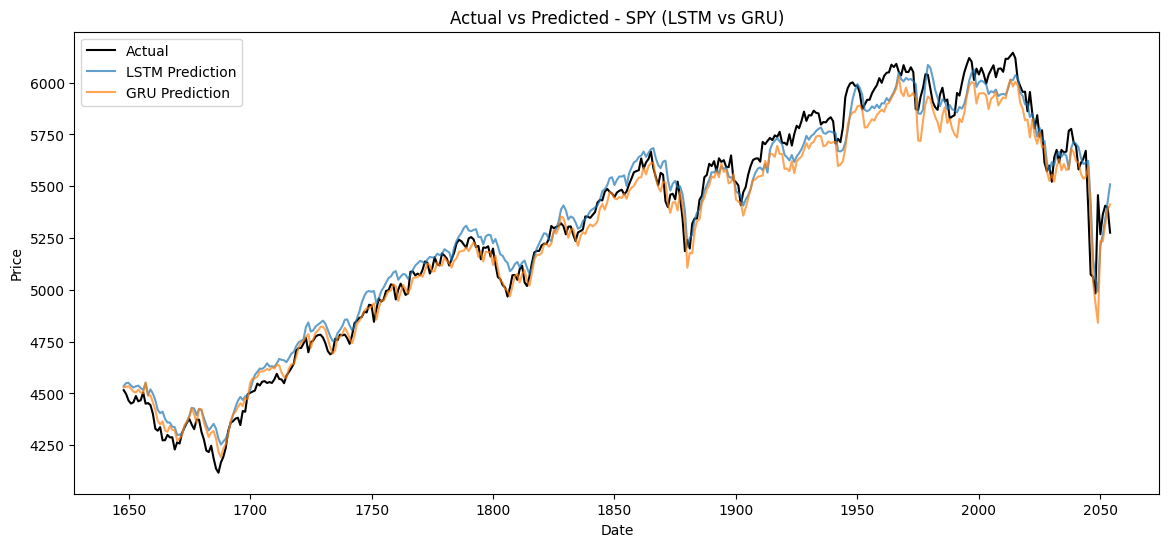

In [1445]:
plt.figure(figsize=(14,6))
plt.plot(dates, y_test_actual, label='Actual', color='black')
plt.plot(dates, pred_lstm, label='LSTM Prediction', alpha=0.7)
plt.plot(dates, pred_gru, label='GRU Prediction', alpha=0.7)
plt.title(f'Actual vs Predicted - {ticker} (LSTM vs GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(False)
plt.show()

In [1535]:
mse_lstm = mean_squared_error(y_test_actual, pred_lstm)
mse_gru = mean_squared_error(y_test_actual, pred_gru)

r2_lstm = r2_score(y_test_actual, pred_lstm)
r2_gru = r2_score(y_test_actual, pred_gru)

print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

LSTM - MSE: 141236.6232, R²: 0.5340
GRU  - MSE: 4851.6563, R²: 0.9840


# put spy_return as index number 1

In [37]:
return_data = return_data.reindex(columns=["SPY_return"] + list(return_data.columns.drop("SPY_return")))

In [38]:
n = return_data.columns.to_list()
print(f"Features used in the model: {n}")


Features used in the model: ['SPY_return', 'QQQ_Close', '^RUT', '^VIX', 'EMA_20', '^GDAXI', 'MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price', 'UNG', 'abs_vix', 'SLV', 'stdev', 'BTC-USD', 'EMA_50', 'EMA_200', '^TNX', 'USO', 'IWM_avg5d', 'shiler pe', 'JPY=X', 'GLD', 'SPY_AbsChange', 'SPY_Volume', '^N225', 'CPER', 'CNYUSD=X', 'before_high-low', 'abs_vol', 'IWM_std_5d', 'yield_curve', 'IEI', 'DX-Y.NYB', 'EUR=X', 'avgreturn10d', '2Y_Yield', 'EUR', 'SPY_RSI', 'DXY', 'JPY', 'ds']


# Return data

In [26]:
#x1 = return_data.drop(columns=['SPY_return','ds'])
#y1 = return_data['SPY_return']
cols = ['SPY_return', 'QQQ_Close', '^RUT', 'abs_vix','MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price','SPY_AbsChange','abs_vol','2Y_Yield','EUR', 'SPY_RSI', 'DXY', 'JPY' ]
scale1 = MinMaxScaler()
return_data_cleaned = return_data.drop(columns=['ds'])
return_data_cleaned = return_data_cleaned[cols]
return_data_scaled = scale1.fit_transform(return_data_cleaned)

In [28]:
return_data_cleaned.head()

,SPY_return,QQQ_Close,^RUT,abs_vix,MSFT,stdev_5,^FTSE,GOOG,AAPL,high-low,avgreturn5d,abs_yield_curve,std_price,SPY_AbsChange,abs_vol,2Y_Yield,EUR,SPY_RSI,DXY,JPY
0,-0.269012,-0.043024,-0.296631,11.77,0.350635,0.316581,-0.655697,1.775112,0.066658,14.760010,-0.082739,1.243,3.722485,0.336624,3155240000,-3.333333,0.93338,54.669773,100.160004,113.809998
1,0.656459,0.864767,1.585499,11.07,0.889458,0.424201,-0.012591,0.556575,-0.091620,17.949951,0.107903,1.261,4.904624,-0.269012,3816950000,4.310345,0.92930,61.857468,100.349998,112.779999
2,0.802609,0.988757,0.966249,10.81,0.251904,0.528980,0.197196,1.432266,1.592078,10.670166,0.233150,1.293,9.878119,0.656459,3849340000,1.652893,0.93208,63.926955,100.029999,113.839996
3,-0.073538,-0.020502,-0.494775,10.63,0.926479,0.459317,-0.040477,-0.421220,0.049234,6.909912,0.290628,1.298,12.248578,1.464337,3611510000,-1.626016,0.93006,63.965540,100.379997,113.292999
4,-0.086646,0.099017,-0.356210,10.58,2.349481,0.486897,0.321162,-1.062304,0.008170,7.399902,0.205974,1.261,13.370660,-0.073538,3137420000,0.826446,0.93607,59.510150,100.529999,114.455002


In [27]:
return_1  =  return_data_cleaned



In [29]:
return_1.head()

,SPY_return,QQQ_Close,^RUT,abs_vix,MSFT,stdev_5,^FTSE,GOOG,AAPL,high-low,avgreturn5d,abs_yield_curve,std_price,SPY_AbsChange,abs_vol,2Y_Yield,EUR,SPY_RSI,DXY,JPY
0,-0.269012,-0.043024,-0.296631,11.77,0.350635,0.316581,-0.655697,1.775112,0.066658,14.760010,-0.082739,1.243,3.722485,0.336624,3155240000,-3.333333,0.93338,54.669773,100.160004,113.809998
1,0.656459,0.864767,1.585499,11.07,0.889458,0.424201,-0.012591,0.556575,-0.091620,17.949951,0.107903,1.261,4.904624,-0.269012,3816950000,4.310345,0.92930,61.857468,100.349998,112.779999
2,0.802609,0.988757,0.966249,10.81,0.251904,0.528980,0.197196,1.432266,1.592078,10.670166,0.233150,1.293,9.878119,0.656459,3849340000,1.652893,0.93208,63.926955,100.029999,113.839996
3,-0.073538,-0.020502,-0.494775,10.63,0.926479,0.459317,-0.040477,-0.421220,0.049234,6.909912,0.290628,1.298,12.248578,1.464337,3611510000,-1.626016,0.93006,63.965540,100.379997,113.292999
4,-0.086646,0.099017,-0.356210,10.58,2.349481,0.486897,0.321162,-1.062304,0.008170,7.399902,0.205974,1.261,13.370660,-0.073538,3137420000,0.826446,0.93607,59.510150,100.529999,114.455002


In [439]:
print(return_1.shape)

(2071, 46)


In [295]:
window = 5
x1, y1 = create_sequences_multifeature(return_1, window)

KeyError: (5, 0)

In [247]:
split = int(0.8 * len(x1))
X_train, X_test = x1[:split], x1[split:]
y_train, y_test = y1[:split], y1[split:]
print(x1.shape[2])

1


In [24]:
return_1.head()

,SPY_return,QQQ_Close,^RUT,abs_vix,MSFT,stdev_5,^FTSE,GOOG,AAPL,high-low,...,2Y_Yield,EUR,SPY_RSI,DXY,JPY,SPY_return_lag_1,SPY_return_lag_2,SPY_return_lag_3,SPY_return_lag_4,SPY_return_lag_5
5,-0.600954,-0.831508,-1.340191,11.88,-0.988134,0.581326,-0.918644,-2.549482,-0.262374,17.969971,...,0.000000,0.93336,56.071596,100.430000,114.667999,-0.086646,-0.073538,0.802609,0.656459,-0.269012
6,-0.088991,0.019240,0.701751,11.99,-0.736991,0.506387,-0.271122,-0.689241,-0.230199,11.880127,...,-2.459016,0.93383,54.943062,99.510002,113.650002,-0.600954,-0.086646,-0.073538,0.802609,0.656459
7,0.029836,0.496187,-0.043322,11.81,-1.655074,0.249146,0.119732,-0.137429,6.098040,16.699951,...,2.521008,0.92560,52.223722,99.639999,112.742996,-0.088991,-0.600954,-0.086646,-0.073538,0.802609
8,0.057031,-0.114303,-0.279154,11.93,-0.644847,0.267195,0.465687,0.356295,-0.170875,12.320068,...,-0.819672,0.92873,55.686728,99.849998,113.310997,0.029836,-0.088991,-0.600954,-0.086646,-0.073538
9,0.726476,0.542384,1.503570,10.97,0.807349,0.473796,0.665192,0.370687,0.427937,10.430176,...,0.000000,0.92922,60.962463,99.870003,112.789001,0.057031,0.029836,-0.088991,-0.600954,-0.086646


In [39]:
def for_sequence(data, window_size,col):
    for i in range(1,window_size+1):
        data[f'{col}_lag_{i}'] = data[col].shift(i)
    return data
return_1 = for_sequence(return_1, 5, 'SPY_return')
return_1 = return_1.dropna()


C:\Users\OMER\AppData\Local\Temp\ipykernel_23536\1457904763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}_lag_{i}'] = data[col].shift(i)


In [40]:

#return_1 = return_1[cols]
x1 = return_1.drop(columns=['SPY_return'])
y1 = return_1['SPY_return']

# for no sequence (best resault so far, using shift[5])

### 1

In [33]:
# Scaling
scaler_X, scaler_y = RobustScaler(), RobustScaler()
X_scaled = scaler_X.fit_transform(x1)
y_scaled = scaler_y.fit_transform(y1.values.reshape(-1, 1))
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split data
split_index = int(0.9 * len(X_scaled))
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]
#train_dates, test_dates = dates[:split_index], dates[split_index:]

In [ ]:
window_size = 5
# Scaling the data for the model
scaler_1 = RobustScaler()
scaled_data_ = scaler_1.fit_transform(return_1)
X, y = create_sequences_multifeature(scaled_data_, window_size)
#scaler_y = scaler_1.fit(y.reshape(-1, 1))
# Scaling the data for the model

split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(X.shape[2])

76


In [428]:


# 1) Your raw arrays x1 (shape: [n_samples, n_features]) and y1 ([n_samples,])
window = 5

# 2) Scale features and target
scaler_X = RobustScaler().fit(x1)
scaler_y = RobustScaler().fit(y1.values.reshape(-1,1))

Xs = scaler_X.transform(x1)              # → (n_samples, n_features)
ys = scaler_y.transform(y1.values.reshape(-1,1))  # → (n_samples, 1)

# 3) Build sequences of length=window
def create_sequences_multifeature(data, targets, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(data)):
        X_seq.append(data[i-window_size:i, :])  # (window_size, n_features)
        y_seq.append(targets[i, 0])             # the scaled return at t=i
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences_multifeature(Xs, ys, window)

# 4) Split into train/test
split_index = int(0.9 * len(X_seq))
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

print("X_train.shape:", X_train.shape)  # → (n_train, window, n_features)
print("y_train.shape:", y_train.shape)  # → (n_train,)






X_train.shape: (1827, 5, 75)
y_train.shape: (1827,)


In [429]:
model_gru = Sequential([
    GRU(256, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    GRU(128, return_sequences=True),
    GRU(98, return_sequences=True),
    GRU(64, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(10, activation='relu'),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 2

In [34]:
model_gru = Sequential([
    GRU(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True),
    GRU(98, return_sequences=True),
    GRU(64, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(10, activation='relu'),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(x1.shape[0], x1.shape[1])),
    GRU(44),
    Dense(32, activation='relu'),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 3

In [35]:
pred_gru = model_gru.predict(X_test)
y_pred_inverse = scaler_y.inverse_transform(pred_gru)
#y_test_reshaped   = y_test.reshape(-1, 1)
#y_test_inverse    = scaler_y.inverse_transform(y_test_reshaped).flatten()
y_test_inverse = scaler_y.inverse_transform(y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


In [420]:
#pred_lstm = model_lstm.predict(X_test)
pred_gru = model_gru.predict(X_test)

# reset the scaler to the original price range
#price_scaler = MinMaxScaler()
price_scaler = RobustScaler()
price_scaler.min_, price_scaler.scale_ = scale1.min_[0], scale1.scale_[0]
#pred_lstm = price_scaler.inverse_transform(pred_lstm)
pred_gru = price_scaler.inverse_transform(pred_gru)
y_test_actual = price_scaler.inverse_transform(y_test.reshape(-1, 1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


AttributeError: 'RobustScaler' object has no attribute 'center_'

In [290]:
#mse_lstm = mean_squared_error(y_test_actual, pred_lstm)
mse_gru = mean_squared_error(y_test_actual, pred_gru)

#r2_lstm = r2_score(y_test_actual, pred_lstm)
r2_gru = r2_score(y_test_actual, pred_gru)

print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

LSTM - MSE: 8808723.0540, R²: -26.9813
GRU  - MSE: 63.1383, R²: 0.9159


In [36]:

mse_gru = mean_squared_error(y_test_inverse, y_pred_inverse)

    
r2_gru = r2_score(y_test_inverse, y_pred_inverse)


print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

GRU  - MSE: 0.0719, R²: 0.9564


GRU  - MSE: 0.0717, R²: 0.9565


In [19]:
# y_test is shape (n_test,1), y_pred_inverse is (n_test,1)
actual = y_test_inverse.flatten()          # → 1-D array
pred   = y_pred_inverse.flatten()  # → 1-D array

check_df = pd.DataFrame({
    "Actual":    actual,
    "Predicted": pred
})

check_df.tail(10)

,Actual,Predicted
197,-4.839563,-5.006712
198,-5.974961,-6.026467
199,-0.233147,-0.671777
200,-1.570052,-1.443027
201,9.515388,7.866687
202,-3.460758,-2.602765
203,1.809210,2.029879
204,0.794471,0.441792
205,-0.172778,-0.578989
206,-2.240837,-1.928620


In [20]:
check_df.head(20)
check_df['gp_present']= np.abs(check_df['Actual'] - check_df['Predicted'])
check_df['mean_10'] = check_df['gp_present'].mean()
check_df['above_mean'] = (check_df['gp_present'] > check_df['mean_10']).astype(int)
check_df['diffrent_sign'] = (check_df['Actual'] * check_df['Predicted'] < 0).astype(int)
check_df['above_mean'].tail(20)

187    0
188    1
189    1
190    0
191    0
192    0
193    1
194    1
195    0
196    1
197    1
198    0
199    1
200    1
201    1
202    1
203    1
204    1
205    1
206    1
Name: above_mean, dtype: int64

In [21]:
print(check_df[['Actual','Predicted','above_mean','diffrent_sign']].head(25))
check_df['price_actual'] = 300 * (1 + check_df['Actual'] / 100).cumprod()
check_df['price_predicted'] = 300 * (1 + check_df['Predicted'] / 100).cumprod()

      Actual  Predicted  above_mean  diffrent_sign
0  -0.252593  -0.318111           0              0
1  -0.156213  -0.217744           0              0
2  -0.306517  -0.419926           1              0
3   0.393359   0.252137           1              0
4   0.157243  -0.017622           1              1
5   0.090732  -0.022392           1              1
6  -0.408365  -0.397962           0              0
7   0.267556   0.072653           1              0
8   0.619532   0.388920           1              0
9   0.508444   0.387732           1              0
10  0.544877   0.401192           1              0
11  0.101670   0.012962           0              0
12  0.074107  -0.081984           1              1
13  1.020807   0.823043           1              0
14 -0.876303  -0.675483           1              0
15  0.551703   0.540285           0              0
16  0.282620   0.149337           1              0
17  0.638938   0.507873           1              0
18 -1.392754  -1.255632        

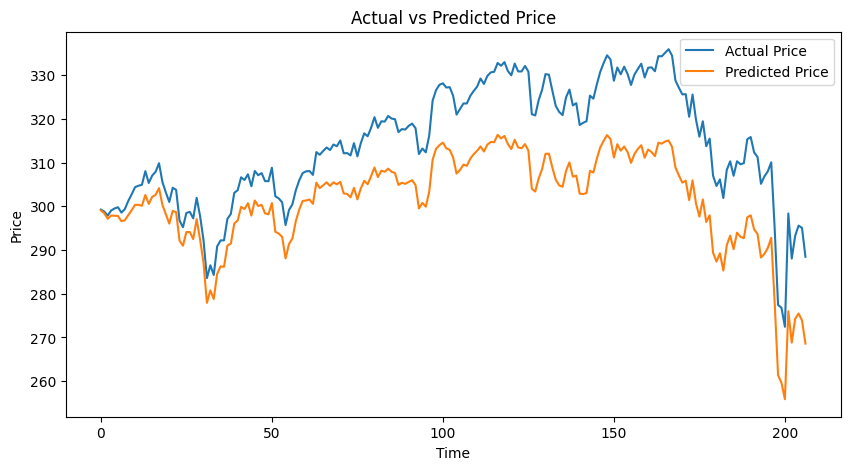

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(check_df['price_actual'], label='Actual Price')
plt.plot(check_df['price_predicted'], label='Predicted Price')
plt.legend()
plt.title('Actual vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()